# M2177.003100 Deep Learning <br> TensorFlow Basics

Copyright (C) Data Science & Artificial Intelligence Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Seonwoo Min, September 2017

### Some helpful tutorials and references for TensorFlow Basics:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [1] TensorFlow official tutorials: Graphs and Sessions. [[link]](https://www.tensorflow.org/programmers_guide/graphs)
- [2] TensorFlow official tutorials: Saving and Restore. [[link]](https://www.tensorflow.org/programmers_guide/saved_model)
- [3] TensorFlow official tutorials: Exporting and Importing a MetaGraph. [[link]](https://www.tensorflow.org/api_guides/python/meta_graph)
- [4] Danijar Hafner. "Structing Your TensorFlow Models" [[link]](https://danijar.com/structuring-your-tensorflow-models/)

---
## Load datasets (MNIST)

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import os
%matplotlib inline

#Matplotlib configurations
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
    
#TensorFlow configureations
conf = tf.ConfigProto()
conf.gpu_options.per_process_gpu_memory_fraction = 0.2
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./DATA/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./DATA/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./DATA/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./DATA/t10k-labels-idx1-ubyte.gz


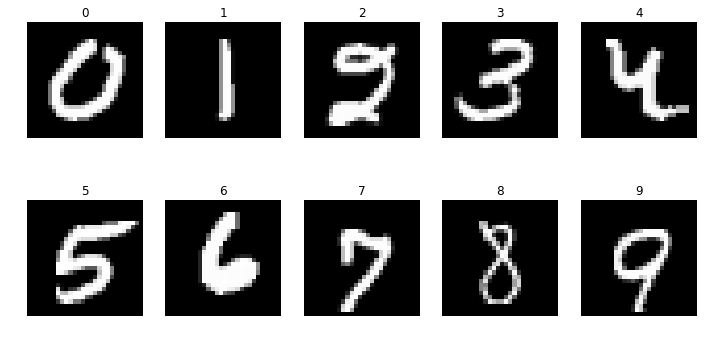

In [3]:
mnist = tf.examples.tutorials.mnist.input_data.read_data_sets("./DATA")
X_train = mnist.train.images.reshape(-1, 28, 28)
Y_train = mnist.train.labels
X_val = mnist.test.images.reshape(-1, 28, 28)
Y_val = mnist.test.labels

#Show MNIST data examples
idx = 0
for i in range(10):
    while(1):
        if Y_train[idx] == i:
            break
        else:
            idx += 1

    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(i)
    plt.axis('off')

---
## Structuring your TensorFlow model using python class

### Model Construction

In [4]:
# Define our model as a class
# It includes our model architecture, loss function, optimizer, and evaluation metrics
class simple_model(object):
    def __init__(self):
        # Define input variables 
        self.inputs = tf.placeholder(tf.float32, [None, 28, 28])
        self.targets = tf.placeholder(tf.int64, [None])
        self.is_training = tf.placeholder(tf.bool)

        # Define model architecture
        with tf.variable_scope('L1'):
            L1 = tf.contrib.layers.flatten(self.inputs)
            L1 = tf.layers.dense(L1, 80, activation=tf.nn.relu)
        with tf.variable_scope('L2'):
            L2 = tf.layers.dense(L1, 40, activation=tf.nn.relu)
        with tf.variable_scope('Output'):
            self.outputs = tf.layers.dense(L2, 10, activation=None)
        
        # Define loss function and optimizer
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.outputs, labels=tf.one_hot(self.targets,10)), name="loss")
        self.optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(self.loss)
        
        # Variables for evaluation
        corr = tf.equal(self.targets, tf.argmax(self.outputs,1))
        self.accuracy = tf.reduce_mean(tf.cast(corr, tf.float32), name='accuracy')   

### A function for model training and evaluation

In [5]:
# Create a function to train and evaluata a model
# You can reuse this function throughout the assignment
def run_model(session, model, X, Y, epochs=1, batch_size=500, is_training=False):
    # For training the model
    if is_training:
        for epoch in range(epochs):
            total_loss = 0
            # Iterate over the entire dataset
            for i in range(int(X.shape[0] / batch_size)):
                _, cost_val = sess.run([model.optimizer, model.loss], 
                                       feed_dict={model.inputs: X[i*batch_size:(i+1)*batch_size],
                                                  model.targets: Y[i*batch_size:(i+1)*batch_size],
                                                  model.is_training: is_training})
                total_loss += cost_val
            print("Epoch: %02d \t Average loss: %.4f" % (epoch+1, total_loss / X.shape[0] * batch_size))
        print("Training done!")

    # Evaluate loss and accuracy of the model
    else:
        loss, accuracy = 0.0, 0.0
        for i in range(int(X.shape[0] / batch_size)):
            l, a = sess.run([model.loss, model.accuracy],
                            feed_dict={model.inputs: X[i*batch_size:(i+1)*batch_size],
                                       model.targets: Y[i*batch_size:(i+1)*batch_size],
                                       model.is_training: is_training})
            loss += l
            accuracy += a
        return (loss / (X.shape[0] / batch_size), accuracy / (X.shape[0] / batch_size))

### Model training

In [9]:
# Clear old variables
tf.reset_default_graph()    

# Declare simple model
model = simple_model()    
    
# Now, train and evaluate the model
with tf.Session(config=conf) as sess:   
    sess.run(tf.global_variables_initializer())
    run_model(sess, model, X_train, Y_train, epochs=20, is_training=True)
    print("(Loss, Accuracy) on Training Dataset (%.4f, %.2f)" % run_model(sess, model, X_train, Y_train))
    print("(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))
    
    #Save your final model
    saver = tf.train.Saver()
    saver.save(sess, "./model_checkpoints/model_final")

Epoch: 01 	 Average loss: 2.0922
Epoch: 02 	 Average loss: 1.5083
Epoch: 03 	 Average loss: 1.0474
Epoch: 04 	 Average loss: 0.7951
Epoch: 05 	 Average loss: 0.6583
Epoch: 06 	 Average loss: 0.5749
Epoch: 07 	 Average loss: 0.5191
Epoch: 08 	 Average loss: 0.4793
Epoch: 09 	 Average loss: 0.4495
Epoch: 10 	 Average loss: 0.4264
Epoch: 11 	 Average loss: 0.4077
Epoch: 12 	 Average loss: 0.3924
Epoch: 13 	 Average loss: 0.3795
Epoch: 14 	 Average loss: 0.3684
Epoch: 15 	 Average loss: 0.3587
Epoch: 16 	 Average loss: 0.3500
Epoch: 17 	 Average loss: 0.3423
Epoch: 18 	 Average loss: 0.3353
Epoch: 19 	 Average loss: 0.3290
Epoch: 20 	 Average loss: 0.3231
Training done!
(Loss, Accuracy) on Training Dataset (0.3194, 0.91)
(Loss, Accuracy) on Validataion Dataset (0.3115, 0.91)


---
## TensorFlow model save & restore

The TensorFlow save method saves three kinds of files-.meta, .data, .index- because it stores the **graph structure** separately from the **variable values**. The *.meta* file describes the saved graph structure, so you need to import it before restoring the checkpoint (otherwise it doesn't know what variables the saved checkpoint values correspond to). *.data* stores the values of each variable in the graph, and *.index* identifies the checkpiont. Hence all the three kinds of files are required when loading your model.

### Model load

In [16]:
# Clear old variables
tf.reset_default_graph()  

with tf.Session(config=conf) as sess:
    #Load your final model
    model = simple_model()  
    saver = tf.train.Saver()
    saver.restore(sess, "./model_checkpoints/model_final")
    print("(Loss, Accuracy) on Test Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))

INFO:tensorflow:Restoring parameters from ./model_checkpoints/model_final
(Loss, Accuracy) on Test Dataset (1.6962, 0.57)


### Model load with a var_list

In [17]:
# Clear old variables
tf.reset_default_graph()  

with tf.Session(config=conf) as sess:
    #Variables in your model
    model = simple_model()  
    var_list = [v for v in tf.trainable_variables()]
    var_list_names = [v.op.name for v in tf.trainable_variables()]
    print(var_list_names)
    
    #Additional variable
    tf.get_variable("Additionl_Variable", 10)
    var_list_new = [v.op.name for v in tf.trainable_variables()]
    print(var_list_new)
    
    #Restore with a var_list
    saver = tf.train.Saver(var_list = var_list)
    saver.restore(sess, "./model_checkpoints/model_final")
    
    print("(Loss, Accuracy) on Test Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))

['L1/dense/kernel', 'L1/dense/bias', 'L2/dense/kernel', 'L2/dense/bias', 'Output/dense/kernel', 'Output/dense/bias']
['L1/dense/kernel', 'L1/dense/bias', 'L2/dense/kernel', 'L2/dense/bias', 'Output/dense/kernel', 'Output/dense/bias', 'Additionl_Variable']
INFO:tensorflow:Restoring parameters from ./model_checkpoints/model_final
(Loss, Accuracy) on Test Dataset (1.6962, 0.57)


### Model load with a MetaGraph

In [18]:
# Clear old variables
tf.reset_default_graph()  

with tf.Session(config=conf) as sess:
    #Restore from MetaGraph
    saver = tf.train.import_meta_graph('./model_checkpoints/model_final.meta')
    saver.restore(sess, "./model_checkpoints/model_final")

    op_names = [op.name+":0" for op in tf.get_default_graph().get_operations()]     
    print(op_names)
    
    batch_size = 500
    loss, accuracy = 0.0, 0.0
    for i in range(int(X_val.shape[0] / batch_size)):
        l, a = sess.run([op_names[103], op_names[172]],
                        feed_dict={op_names[0]: X_val[i*batch_size:(i+1)*batch_size],
                                   op_names[1]: Y_val[i*batch_size:(i+1)*batch_size],
                                   op_names[2]: False})
        loss += l
        accuracy += a
    print("(Loss, Accuracy) on Test Dataset (%.4f, %.2f)" % (loss / (X_val.shape[0] / batch_size), accuracy / (X_val.shape[0] / batch_size)))

INFO:tensorflow:Restoring parameters from ./model_checkpoints/model_final
['save/RestoreV2/shape_and_slices:0', 'save/RestoreV2/tensor_names:0', 'save/SaveV2/shape_and_slices:0', 'save/SaveV2/tensor_names:0', 'save/Const:0', 'save/RestoreV2:0', 'Const_1:0', 'ArgMax/dimension:0', 'GradientDescent/learning_rate:0', 'gradients/softmax_cross_entropy_with_logits_sg_grad/ExpandDims_1/dim:0', 'gradients/softmax_cross_entropy_with_logits_sg_grad/ExpandDims/dim:0', 'gradients/loss_grad/Maximum/y:0', 'gradients/loss_grad/Const_1:0', 'gradients/loss_grad/Const:0', 'gradients/loss_grad/Shape_2:0', 'gradients/loss_grad/Prod_1:0', 'gradients/loss_grad/Maximum:0', 'gradients/loss_grad/Reshape/shape:0', 'gradients/grad_ys_0:0', 'gradients/Shape:0', 'gradients/Fill:0', 'gradients/loss_grad/Reshape:0', 'Const:0', 'softmax_cross_entropy_with_logits_sg/Slice_2/begin:0', 'softmax_cross_entropy_with_logits_sg/Sub_2/y:0', 'softmax_cross_entropy_with_logits_sg/concat_1/axis:0', 'softmax_cross_entropy_with_log

ValueError: Cannot feed value of shape (500, 28, 28) for Tensor 'save/RestoreV2/shape_and_slices:0', which has shape '(6,)'